In [8]:
import urllib.parse
import urllib.request
import pandas as pd
import re
from tqdm.notebook import tqdm
import numpy as np
import pickle
import missingno as msno
import multiprocessing 
from multiprocessing import Manager, Pool
num_cores = int(110)
import random
from datar import f
from datar.dplyr import mutate, filter, if_else
from datar.tibble import tibble

In [9]:
# load data : key: kinase, value: sequence
with open('/home/hb/python/phospho/kw/1traintruedata생성/mappingdict(KIN_ACC_ID)HMM.pickle', 'rb') as fr:
    mappingdict = pickle.load(fr)

# 정답 데이터
df = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Kinase_Substrate_Dataset',
                encoding = 'ISO-8859-1', header = 2, delimiter = '\t') 
print(df.columns)
df.tail()

Index(['GENE', 'KINASE', 'KIN_ACC_ID', 'KIN_ORGANISM', 'SUBSTRATE',
       'SUB_GENE_ID', 'SUB_ACC_ID', 'SUB_GENE', 'SUB_ORGANISM', 'SUB_MOD_RSD',
       'SITE_GRP_ID', 'SITE_+/-7_AA', 'DOMAIN', 'IN_VIVO_RXN', 'IN_VITRO_RXN',
       'CST_CAT#'],
      dtype='object')


,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
21224,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21225,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21226,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21227,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
21228,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [10]:
df = df.dropna(subset=['KIN_ACC_ID'])
print(df.columns)
df.reset_index(drop=True, inplace=True)
df.tail()

Index(['GENE', 'KINASE', 'KIN_ACC_ID', 'KIN_ORGANISM', 'SUBSTRATE',
       'SUB_GENE_ID', 'SUB_ACC_ID', 'SUB_GENE', 'SUB_ORGANISM', 'SUB_MOD_RSD',
       'SITE_GRP_ID', 'SITE_+/-7_AA', 'DOMAIN', 'IN_VIVO_RXN', 'IN_VITRO_RXN',
       'CST_CAT#'],
      dtype='object')


,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
21221,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21222,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21223,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21224,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
21225,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [11]:
df['KIN_ACC_ID'] = df['KIN_ACC_ID'].apply(lambda x:x.replace("-2","")
                                            .replace("-3","")
                                            .replace("-8","")
                                            .replace("-10",""))
df.reset_index(drop=True, inplace=True)
df.tail()

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
21221,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21222,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21223,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21224,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
21225,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


<AxesSubplot:>

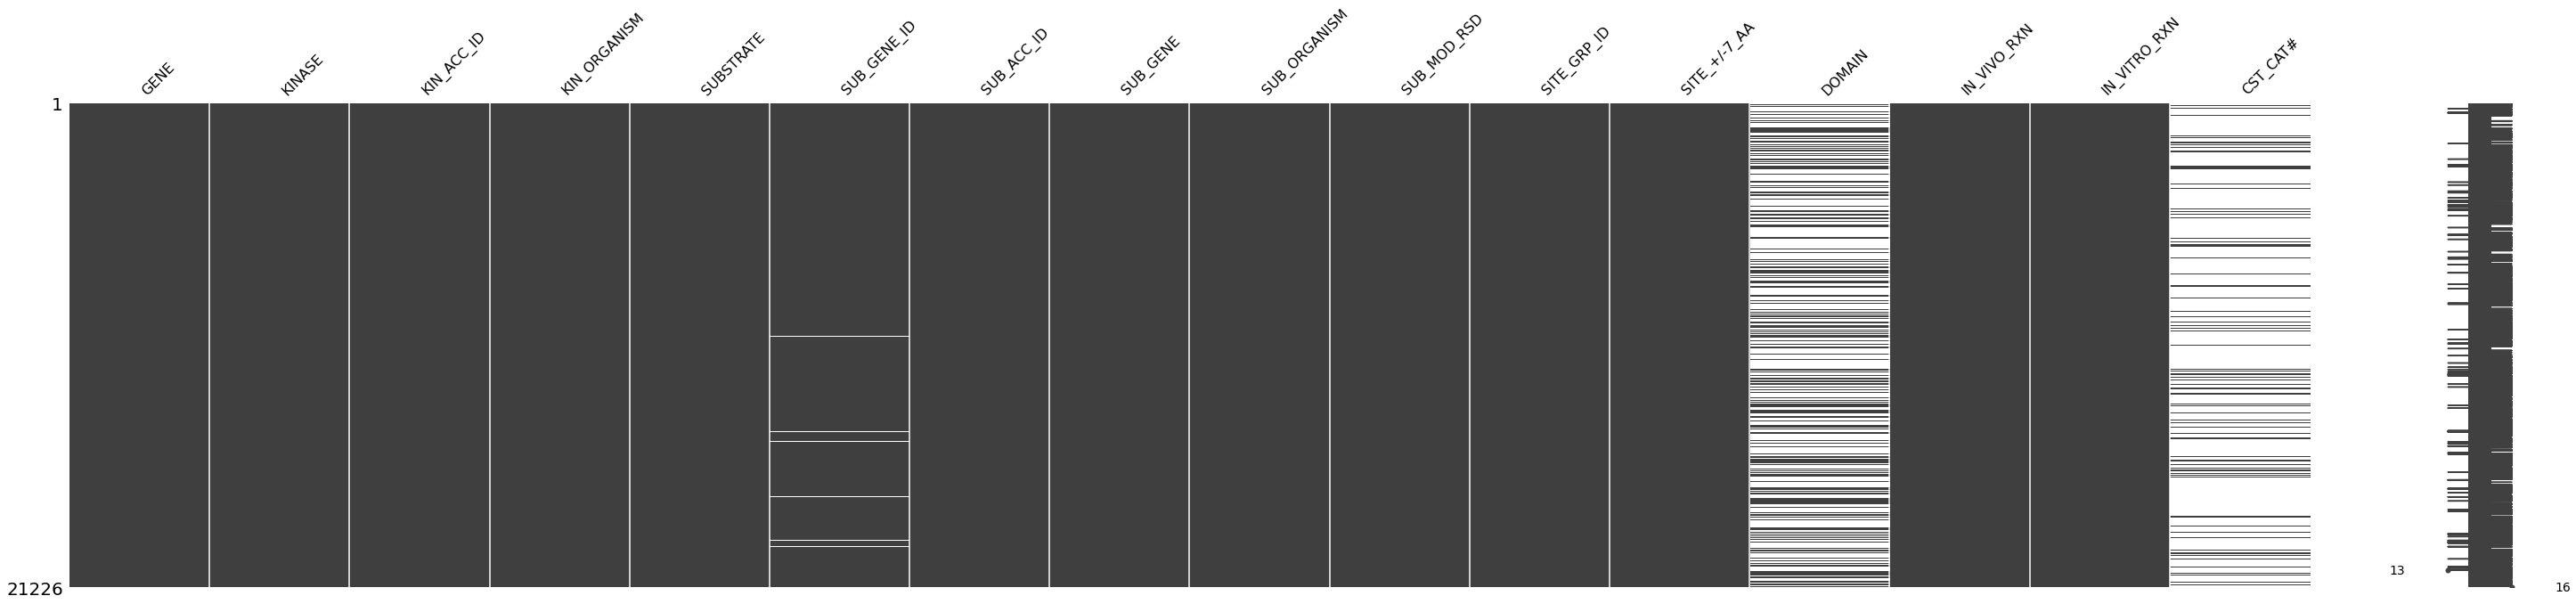

In [12]:
msno.matrix(df, figsize=(50,10)) # 결측치 조회

In [14]:
df

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
0,Dyrk2,DYRK2,Q5U4C9,mouse,NDEL1,83431.0,Q9ERR1,Ndel1,mouse,S336,1869686801,LGSsRPSsAPGMLPL,NaN,,X,NaN
1,Pak2,PAK2,Q64303,rat,MEK1,170851.0,Q01986,Map2k1,rat,S298,448284,RtPGRPLsSYGMDSR,Pkinase,,X,9128; 98195
2,Pak2,PAK2,Q64303,rat,PRKD1,85421.0,Q9WTQ1,Prkd1,rat,S203,449896,GVRRRRLsNVsLTGL,NaN,X,,NaN
3,Pak2,PAK2,Q64303,rat,prolactin,24683.0,P01237,Prl,rat,S206,451732,IRCLRRDsHKVDNYL,Hormone_1,,X,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Pak2,PAK2,Q64303,rat,prolactin,5617.0,P01236,PRL,human,S207,451732,LHCLRRDsHKIDNYL,Hormone_1,,X,NaN
21221,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21222,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21223,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN


In [13]:
df['KINseq'] = df.apply(lambda x: mappingdict[x['KIN_ACC_ID']], axis=1)
df['Length'] = df.apply(lambda x: len(x['KINseq']), axis=1)
df['Length'].plot()
len_info = df['Length'].agg([np.max, np.min, np.mean])
max_len, min_len, mean_len = len_info
print(len_info)

KeyError: 'Q9BQI3'